In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import re
import string
import nltk
import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
pd.set_option("display.max_colwidth", 200)
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from nltk.corpus import wordnet

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
# Read the data
path = '/content/drive/MyDrive/Text classification using Random Forest/'
df = pd.read_csv(path + 'kilauea_relevant_tweets_BERT_1.csv')

In [ ]:
df_rel= df[df.Relevance==1]
df_rel.head()

Text  ... Relevance
4   dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...       1.0
7              here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...       1.0
8                                                      recent overflows are largest seen at kilauea lava lake in 10 years:    ...       1.0
9                                   happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...       1.0
11    four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...       1.0

[5 rows x 5 columns]

In [ ]:
# Data types
df_rel.dtypes

Text          object
Date          object
Geo           object
Place         object
Relevance    float64
dtype: object

In [ ]:
# Check missing values if any
df_rel.isnull().sum()/df_rel.shape[0]

Text         0.000000
Date         0.000000
Geo          0.998408
Place        0.981192
Relevance    0.000000
dtype: float64

We can see that 99% of values are missing in Geo column & 98.3% of values are missing in Place column.

### Data preprocessing

In [ ]:
df_rel["Date"]=pd.to_datetime(df_rel["Date"])
df_rel["text"]=df_rel["Text"].apply(lambda x:str(x).lower())
df_rel.shape

(139410, 6)

In [ ]:
volcanic_data=df_rel
volcanic_data.reset_index(inplace=True,drop=True)
volcanic_data.shape
volcanic_data.head()

Text  ...                                                                                                                      text
0  dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...  dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…  
1             here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...             here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…  
2                                                     recent overflows are largest seen at kilauea lava lake in 10 years:    ...                                                     recent overflows are largest seen at kilauea lava lake in 10 years:  
3                                  happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...                                  happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…  
4    four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...    four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…  

[5 rows x 6 columns]

In [ ]:
#volcanic_data=df[(df['text'].str.contains("volcano")) | (df['text'].str.contains("eruption")) | (df['text'].str.contains("volcanic")) 
                #| (df['text'].str.contains("lava")) | (df['text'].str.contains("basalt")) | (df['text'].str.contains("magma"))|
                #(df['text'].str.contains("crater")) | (df['text'].str.contains("ash"))]
#volcanic_data.reset_index(inplace=True,drop=True)
#volcanic_data.shape
#volcanic_data.head()

## Preprocessing

https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/

#### To remove usernames and URLs in the tweets

In [ ]:
def removeInputPattern(pattern, inputString):
    inputString=re.sub(pattern,"",inputString)
    return inputString 

In [ ]:
cleanedTweets=[]
for line in volcanic_data["text"]:
    cleanedTweets.append(removeInputPattern(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|@[\w]+",line))

In [ ]:
volcanic_data["cleanedTweets"]=cleanedTweets

In [ ]:
volcanic_data.head(10)

Text  ...                                                                                                                cleanedTweets
0     dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...     dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…  
1                here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...                here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…  
2                                                        recent overflows are largest seen at kilauea lava lake in 10 years:    ...                                                        recent overflows are largest seen at kilauea lava lake in 10 years:  
3                                     happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...                                     happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…  
4       four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...       four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…  
5              not surprising that it was all lava ... and  calebap  lava was a big deal in  2018  leilaniestates  bestnine…    ...              not surprising that it was all lava ... and  calebap  lava was a big deal in  2018  leilaniestates  bestnine…  
6                                                        recent overflows are largest seen at kilauea lava lake in 10 years:    ...                                                        recent overflows are largest seen at kilauea lava lake in 10 years:  
7       i foresee dark clouds for the 'cerebral' pelosi, ahead, and they're not kilauea volcano plumes of lava darkening th…    ...       i foresee dark clouds for the 'cerebral' pelosi, ahead, and they're not kilauea volcano plumes of lava darkening th…  
8  may-\n•kilauea volcano sprays ash thousands of feet into the air. \n\n•the royal wedding takes place!\n\n•hugh grant and…    ...  may-\n•kilauea volcano sprays ash thousands of feet into the air. \n\n•the royal wedding takes place!\n\n•hugh grant and…  
9                                                                     2018willgodown as the year  hawaii increased in size.\n   ...                                                                     2018willgodown as the year  hawaii increased in size.\n 

[10 rows x 7 columns]

In [ ]:
volcanic_data["cleanedTweets"]=volcanic_data["cleanedTweets"].str.replace("[^A-Za-z#]"," ")

In [ ]:

# Replace _ by ''
volcanic_data["cleanedTweets"]=volcanic_data["cleanedTweets"].str.replace("_"," ")

In [ ]:

volcanic_data.head(10)

Text  ...                                                                                                           cleanedTweets
0     dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...  dramatic images show hawaii s kilauea volcano erupt  lava spewed hundreds of feet into the air as the volcano kilau   
1                here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...           here s my top   in stories this year     charter school co founder looks to future after  kilauea eruption   
2                                                        recent overflows are largest seen at kilauea lava lake in 10 years:    ...                                                   recent overflows are largest seen at kilauea lava lake in    years   
3                                     happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...                                happy new year  here s where to watch big island fireworks tonight    hawaii  kilauea   
4       four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...  four ways k lauea is redrawing the  map  from burying communities to building new land  this historic eruption is c   
5              not surprising that it was all lava ... and  calebap  lava was a big deal in  2018  leilaniestates  bestnine…    ...         not surprising that it was all lava     and  calebap  lava was a big deal in        leilaniestates  bestnine   
6                                                        recent overflows are largest seen at kilauea lava lake in 10 years:    ...                                                   recent overflows are largest seen at kilauea lava lake in    years   
7       i foresee dark clouds for the 'cerebral' pelosi, ahead, and they're not kilauea volcano plumes of lava darkening th…    ...  i foresee dark clouds for the  cerebral  pelosi  ahead  and they re not kilauea volcano plumes of lava darkening th   
8  may-\n•kilauea volcano sprays ash thousands of feet into the air. \n\n•the royal wedding takes place!\n\n•hugh grant and…    ...  may   kilauea volcano sprays ash thousands of feet into the air     the royal wedding takes place    hugh grant and   
9                                                                     2018willgodown as the year  hawaii increased in size.\n   ...                                                                     willgodown as the year  hawaii increased in size   

[10 rows x 7 columns]

#### Remove Stop Words

In [ ]:
import nltk
nltk.download('stopwords')

# Load list of stop-words
listStopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def removeStopWords(text,listStopwords=None):
    listText = text.split()
    if listStopwords is not None:
        listText = [word for word in listText if word not in 
                    listStopwords]
        
    text = " ".join(listText)
    return text
    

In [ ]:
volcanic_data["cleanedTweets"] = volcanic_data["cleanedTweets"].apply(lambda x:removeStopWords(x,listStopwords=listStopwords))

In [ ]:
volcanic_data.head(10)

Text  ...                                                                                  cleanedTweets
0     dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...  dramatic images show hawaii kilauea volcano erupt lava spewed hundreds feet air volcano kilau
1                here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...                       top stories year charter school co founder looks future kilauea eruption
2                                                        recent overflows are largest seen at kilauea lava lake in 10 years:    ...                                          recent overflows largest seen kilauea lava lake years
3                                     happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...                               happy new year watch big island fireworks tonight hawaii kilauea
4       four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...      four ways k lauea redrawing map burying communities building new land historic eruption c
5              not surprising that it was all lava ... and  calebap  lava was a big deal in  2018  leilaniestates  bestnine…    ...                                  surprising lava calebap lava big deal leilaniestates bestnine
6                                                        recent overflows are largest seen at kilauea lava lake in 10 years:    ...                                          recent overflows largest seen kilauea lava lake years
7       i foresee dark clouds for the 'cerebral' pelosi, ahead, and they're not kilauea volcano plumes of lava darkening th…    ...             foresee dark clouds cerebral pelosi ahead kilauea volcano plumes lava darkening th
8  may-\n•kilauea volcano sprays ash thousands of feet into the air. \n\n•the royal wedding takes place!\n\n•hugh grant and…    ...         may kilauea volcano sprays ash thousands feet air royal wedding takes place hugh grant
9                                                                     2018willgodown as the year  hawaii increased in size.\n   ...                                                          willgodown year hawaii increased size

[10 rows x 7 columns]

In [ ]:
volcanic_data.shape

(139410, 8)

In [ ]:
# Convert to list
text_list= volcanic_data.cleanedTweets.values.tolist()

# Remove Emails
text_list = [re.sub('\S*@\S*\s?', '', sent) for sent in text_list]

# Remove new line characters
text_list = [re.sub('\s+', ' ', sent) for sent in text_list]

# Remove distracting single quotes
text_list = [re.sub("\'", "", sent) for sent in text_list]

#### Tokenize each tweet and remove punctuations

Tokenization breaks the raw text into words, sentences called tokens. These tokens help in understanding the context or developing the model for the NLP.

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(text_list))

print(data_words[:1])

[['dramatic', 'images', 'show', 'hawaii', 'kilauea', 'volcano', 'erupt', 'lava', 'spewed', 'hundreds', 'feet', 'air', 'volcano', 'kilau']]


#### Build Bigram and Trigram Models

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)


In [ ]:
import spacy

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### run this to download en model from spacy in anaconda prompt
#python -m spacy download en

In [ ]:
# Create Bigrams o
data_words_bigrams = make_bigrams(data_words)

# Initialize the spacy 'en' model for lemmatization purpose, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])

# Perform lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['dramatic', 'image', 'show', 'hundred']]


### Topic Modelling

In [ ]:
# The two important inputs to the LDA topic model are the dictionary(id2word) and the corpus. So, let’s create them.
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])



[[(0, 1), (1, 1), (2, 1), (3, 1)]]


A unique id for each word in the document is created using genism. 
The resulting corpus displayed above is a mapping of (word_id, word_frequency).
For example, (0, 1) above implies, word id 0 occurs once in the first document. 

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                #print(topic_keywords)
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  ...                                                                                           Text
0            0  ...  dramatic images show hawaii kilauea volcano erupt lava spewed hundreds feet air volcano kilau
1            1  ...                       top stories year charter school co founder looks future kilauea eruption
2            2  ...                                          recent overflows largest seen kilauea lava lake years
3            3  ...                               happy new year watch big island fireworks tonight hawaii kilauea
4            4  ...      four ways k lauea redrawing map burying communities building new land historic eruption c
5            5  ...                                  surprising lava calebap lava big deal leilaniestates bestnine
6            6  ...                                          recent overflows largest seen kilauea lava lake years
7            7  ...             foresee dark clouds cerebral pelosi ahead kilauea volcano plumes lava darkening th
8            8  ...         may kilauea volcano sprays ash thousands feet air royal wedding takes place hugh grant
9            9  ...                                                          willgodown year hawaii increased size

[10 rows x 5 columns]

In [ ]:
df_dominant_topic.to_csv("./topic_modelling.csv",index=False)

In [ ]:
df_dominant_topic['Dominant_Topic'].unique()

array([9., 0., 2., 6., 5., 8., 3., 4., 1.])

## Sentiment Analysis

Before performing Sentiment analysis, let's perform EDA on relevant Kilauea tweets.

In [ ]:
# Filter relevant & non relevant tweets
data_rel = df[df['Relevance']==1.0].reset_index(drop=True)
data_rel['Date'] = pd.to_datetime(data_rel["Date"])
data_nonrel = df[df['Relevance']==0.0].reset_index(drop=True)
data_nonrel['Date'] = pd.to_datetime(data_nonrel["Date"])

In [ ]:
#Relevant
data_rel.head()

Text  ... Relevance
0  dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...       1.0
1             here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...       1.0
2                                                     recent overflows are largest seen at kilauea lava lake in 10 years:    ...       1.0
3                                  happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...       1.0
4    four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...       1.0

[5 rows x 5 columns]

In [ ]:
data_rel.shape

(139410, 5)

In [ ]:
data_nonrel.head()

Text  ... Relevance
0                 npaf's artist in residence, composer glenn mcclure is at the park at work on his unusual sonification compostions b…    ...       0.0
1  the world's most active volcano is kilauea, in hawaii. [boston globe]  pushawardslizquens  kca  facts  funfacts  coolfacts  uberfacts  ...       0.0
2                 other  volcanoes_nps partners assisting w/ providing info to visitors: on the kvc lanai (fhvnp). volcano house hote…    ...       0.0
3                  while  volcanoes_nps is partially closed due to a lapse of federal funding, hawaiʻi pacific parks association, the…    ...       0.0
4                repost  weatherchannel with get_repost\n・・・\nring in the new year by checking out our favorite images of 2018. above…    ...       0.0

[5 rows x 5 columns]

In [ ]:
data_nonrel.shape

(24028, 5)

1. **Time series of relevant Kilauea tweets**

In [ ]:
#Daily
tweets_daily=data_rel.resample('D', on='Date').count()
# Weekly
tweets_weekly= data_rel.resample('W', on='Date').count()
# Monthly
tweets_monthly= data_rel.resample('M', on='Date').count()

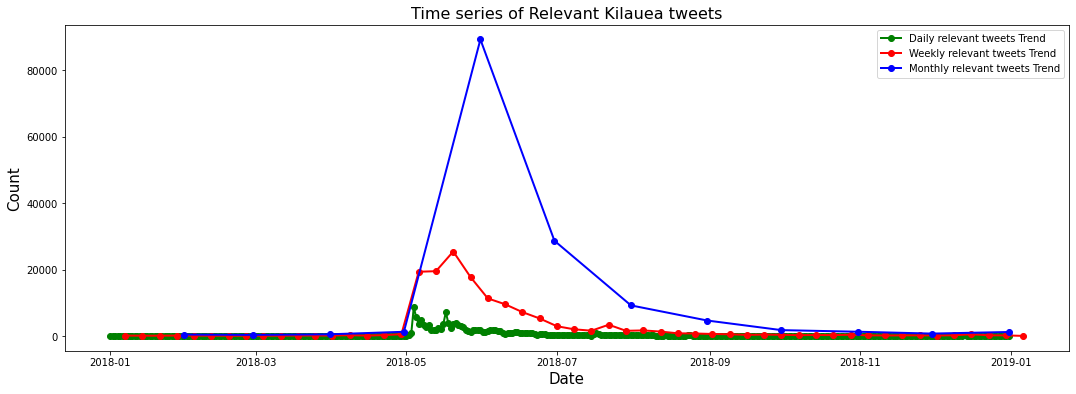

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(tweets_daily.loc[:,'Text'], linestyle='-', linewidth=2, label='Daily relevant tweets Trend',color="g",marker="o")
ax.plot(tweets_weekly.loc[:,'Text'], linestyle='-', linewidth=2, label='Weekly relevant tweets Trend',color="r",marker="o")
ax.plot(tweets_monthly.loc[:,'Text'], linestyle='-', linewidth=2, label='Monthly relevant tweets Trend',color="b",marker="o")
plt.title("Time series of Relevant Kilauea tweets",size=16)
ax.set_ylabel('Count',size=15)
ax.set_xlabel("Date",size=15)
ax.legend();
plt.show()

2. **World map of where those tweets come from**

In [ ]:
# Get longitude & latitude values from Geo column
import re 
import ast
geo_data = data_rel['Geo']

latitude = []
longitude = []

for i in range(len(geo_data)):
  try:
    d = ast.literal_eval(re.search('({.+})', geo_data[i]).group(0))
    lat = d['coordinates'][0]
    lng = d['coordinates'][1]
    latitude.append(lat)
    longitude.append(lng)
  except:
    latitude.append(np.nan)
    longitude.append(np.nan)

In [ ]:
data_rel['latitude'] = latitude
data_rel['longitude'] = longitude
data_rel.head()

Text  ... longitude
0  dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...       NaN
1             here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...       NaN
2                                                     recent overflows are largest seen at kilauea lava lake in 10 years:    ...       NaN
3                                  happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...       NaN
4    four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...       NaN

[5 rows x 7 columns]

In [ ]:
# Get city & country name
place_data = data_rel['Place']

cities = []

for i in range(len(place_data)):
  try:
    d = ast.literal_eval(re.search('({.+})', place_data[i]).group(0))
    place = d['full_name']
    cities.append(place)
  except:
    cities.append(np.nan) 

In [ ]:
data_rel['City'] = cities
data_rel.head()

Text  ... City
0  dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...  NaN
1             here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...  NaN
2                                                     recent overflows are largest seen at kilauea lava lake in 10 years:    ...  NaN
3                                  happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...  NaN
4    four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...  NaN

[5 rows x 8 columns]

Let's check the places in Place column.

In [ ]:
data_rel['City'].dropna().tolist()

['Hawaii, USA',
 'Hawaii, USA',
 'Hawaii, USA',
 'Hawaii, USA',
 'Pikermi, Greece',
 'Hilo, HI',
 'Kilauea, HI',
 'Austin, TX',
 'Holualoa, HI',
 'Washington, DC',
 'Little Rock, AR',
 'Kilauea, HI',
 'Pahoa, HI',
 'Hawaii, USA',
 'Manhattan, NY',
 'Coral Springs, FL',
 'Bowie, MD',
 'Hawaii, USA',
 'Honolulu, HI',
 'Honolulu, HI',
 'Norristown, PA',
 'Hawaii, USA',
 'Anaheim, CA',
 'Hawaii, USA',
 'Honolulu, HI',
 'Ottawa, Ontario',
 'Honolulu, HI',
 'California, USA',
 'South Carolina, USA',
 'Holualoa, HI',
 'Kuala Lumpur City, Kuala Lumpur Federal Territory',
 'Washington, DC',
 'Auckland, New Zealand',
 'Natal, Brazil',
 'Honolulu, HI',
 'Hawaii, USA',
 'Minneapolis, MN',
 'Melbourne, Victoria',
 'Hawaii, USA',
 'Hawaii, USA',
 'Hawaii, USA',
 'Azerbaijan',
 'Hawaii, USA',
 'Santa Maria, CA',
 'Florida, USA',
 'Ewa Gentry, HI',
 'Opihi Junction~  Lanikai',
 'Hilo, HI',
 'Indiana, USA',
 'Pearl City, HI',
 'Rolleston, England',
 'Tysons Corner, VA',
 'Rolleston, England',
 'Arizona

In [ ]:
# Prepare the data for plotting folium map
tweets_data = data_rel[['City','latitude', 'longitude', 'Text']].dropna().reset_index(drop=True)
# # Group the tweets by City
tweets_g = tweets_data.groupby(by = ['City']).agg({'Text' : 'size', 'latitude':'mean', 'longitude':'mean'}).rename(
    columns={'Text':'Value_count'}
).reset_index(drop=False)
tweets_g

City  Value_count   latitude   longitude
0                       Anaheim, CA            1  33.800174 -117.882845
1                        Arvada, CO            1  39.799579 -105.079970
2                       Atlanta, GA            1  33.784760  -84.381850
3                Caracas, Venezuela            1  10.490256  -66.927709
4    Christchurch City, New Zealand            1 -43.543862  172.607234
5                  Donegal, Ireland            1  54.751999   -7.975676
6       Dubai, United Arab Emirates            1  24.975852   55.004755
7                       Hawaii, USA          129  19.587407 -155.514453
8                          Hilo, HI            6  19.710698 -155.074263
9                      Holualoa, HI            3  19.618380 -155.985540
10                     Honolulu, HI           11  21.293454 -157.814923
11                       Idaho, USA            1  43.461700 -113.563000
12                Jeffersontown, KY            1  38.206100  -85.573600
13                       Kailua, HI            2  19.640970 -155.996730
14                      Kaneohe, HI            9  21.421345 -157.793078
15                        Keaau, HI            1  19.621100 -155.042000
16                      Keauhou, HI            1  19.564839 -155.965109
17                    Kentucky, USA            1  36.859031  -83.791737
18                      Kilauea, HI           16  22.211125 -159.410119
19                  London, England            2  51.505332   -0.141342
20                  Los Angeles, CA            5  34.064149 -118.262124
21                    Manhattan, NY            1  40.714200  -74.006400
22                        Miami, FL            1  25.775200  -80.192000
23                  Minneapolis, MN            1  44.977400  -93.264500
24                   Minnesota, USA            1  44.741736  -94.710585
25                    Oklahoma, USA            1  35.778834  -94.855326
26                     Onalaska, WI            1  43.888300  -91.218600
27                        Pahoa, HI            1  19.501000 -154.953000
28                  Princeville, HI            1  22.217214 -159.475933
29                     Pukalani, HI            1  20.840000 -156.344000
30  Riyadh, Kingdom of Saudi Arabia            1  24.639799   46.718026
31               Saint Albans, East            1  51.750789   -0.339490
32                    San Diego, CA            1  32.746834 -117.085898
33                 Sandown, England            2  50.654330   -1.159467
34             Waikoloa Village, HI            1  19.943100 -155.790000
35                   Warsaw, Poland            9  52.210569   21.021937
36                   Washington, DC            1  38.895613  -77.009895

**Create a folium map to see where the tweets come from.**

In [ ]:
# import the library
import folium

# Make an empty map
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

# Show the map
m

In [ ]:
scale_factor = 20000  # For radius
# add marker one by one on the map
for i in range(0,len(tweets_g)):
   folium.Circle(
      location=[tweets_g.iloc[i]['latitude'], tweets_g.iloc[i]['longitude']],
      popup=folium.Popup(tweets_g.iloc[i]['City'] + ' ' + 'Count :'+str(tweets_g.iloc[i]['Value_count'])),
      radius=float(tweets_g.iloc[i]['Value_count'])*scale_factor,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

# Show the map again
m

Size of the bubble indicates the **count of tweets**. We can see the highest number of tweets are coming from **Hawaii**.



```
# This is formatted as code
```

3. **Sentiment over time & Space**

VADER sentiment

*   List item
*   List item


Valence aware dictionary for sentiment reasoning (VADER) is another popular rule-based sentiment analyzer. 

It uses a list of lexical features (e.g. word) which are labeled as positive or negative according to their semantic orientation to calculate the text sentiment.   

Vader sentiment returns the probability of a given input sentence to be 

Positive, negative, and neutral. 

### Sentiment analysis using BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 62.0 MB/s 
     |████████████████████████████████| 3.3 MB 44.8 MB/s 
     |████████████████████████████████| 59 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 59.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# import nltk
# import operator
# nltk.download('vader_lexicon')
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sentimentAnalysisModel = SentimentIntensityAnalyzer()

In [ ]:
# clean_tweets=["1"]*len(texts)
# for i in range(len(texts)):
#     clean_tweets[i]=" ".join(texts[i])

In [ ]:
from transformers import pipeline
nlp = pipeline('sentiment-analysis');

labels = []
scores = []
for i in range(len(volcanic_data)):
  result = nlp(volcanic_data['cleanedTweets'][i]);
  label = result[0]['label']
  labels.append(result[0]['label'])
  if label=='NEGATIVE':
    scores.append(-1*result[0]['score'])
  else:
    scores.append(result[0]['score'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [ ]:
volcanic_data['Sentiment'] = labels 
volcanic_data['sentimentScores'] = scores 

In [ ]:
# volcanic_data["cleanedTweets"]=clean_tweets

In [ ]:
# volcanic_data["sentiment"]=volcanic_data["cleanedTweets"].apply(lambda x:sentimentAnalysisModel.polarity_scores(x))

In [ ]:
# as an output we get dictionary with the probability of each label: positive, neutral and negative 
# using below function we extract the highest probability score
# def calculateHighestSentiment(sentiment):
#     sentiment_score=sentiment["compound"]
#     #maxValue=max(sentiment.items(), key=operator.itemgetter(1))[0]
#     return sentiment_score

In [ ]:
# volcanic_data["sentimentScores"]=volcanic_data["sentiment"].apply(lambda x: calculateHighestSentiment(x))
# del volcanic_data["sentiment"]

In [ ]:
sentiment_data=volcanic_data.copy()

geo_data = sentiment_data['Geo']

latitude = []
longitude = []

for i in range(len(geo_data)):
  try:
    d = ast.literal_eval(re.search('({.+})', geo_data[i]).group(0))
    lat = d['coordinates'][0]
    lng = d['coordinates'][1]
    latitude.append(lat)
    longitude.append(lng)
  except:
    latitude.append(np.nan)
    longitude.append(np.nan)

sentiment_data['latitude'] = latitude
sentiment_data['longitude'] = longitude

# Get city & country name
place_data = sentiment_data['Place']

cities = []

for i in range(len(place_data)):
  try:
    d = ast.literal_eval(re.search('({.+})', place_data[i]).group(0))
    place = d['full_name']
    cities.append(place)
  except:
    cities.append(np.nan) 

sentiment_data['City'] = cities

In [ ]:
del sentiment_data["text"]
del sentiment_data["Geo"]

In [ ]:
sentiment_data.head(10)

Text  ... City
0     dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...  NaN
1                here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...  NaN
2                                                        recent overflows are largest seen at kilauea lava lake in 10 years:    ...  NaN
3                                     happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...  NaN
4       four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...  NaN
5              not surprising that it was all lava ... and  calebap  lava was a big deal in  2018  leilaniestates  bestnine…    ...  NaN
6                                                        recent overflows are largest seen at kilauea lava lake in 10 years:    ...  NaN
7       i foresee dark clouds for the 'cerebral' pelosi, ahead, and they're not kilauea volcano plumes of lava darkening th…    ...  NaN
8  may-\n•kilauea volcano sprays ash thousands of feet into the air. \n\n•the royal wedding takes place!\n\n•hugh grant and…    ...  NaN
9                                                                     2018willgodown as the year  hawaii increased in size.\n   ...  NaN

[10 rows x 10 columns]

In [ ]:
sentiment_data.to_csv(path+'sentiment_data.csv')

In [ ]:
sentiment_data.to_csv("./sentiment_scores.csv",index=False)

In [ ]:
import seaborn as sns

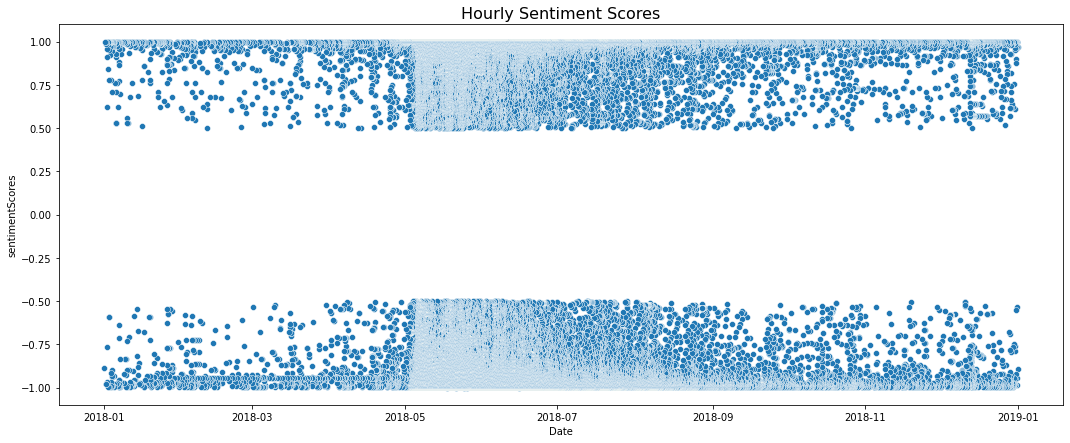

In [ ]:
fig=plt.subplots(figsize=(18,7))
sns.scatterplot(data=sentiment_data,x="Date",y="sentimentScores")
plt.title("Hourly Sentiment Scores",size=16)
plt.show()

In [ ]:
# grouping the data based on daily basis to get a daily basis count of tweets
sentiment_daily=sentiment_data.resample('D', on='Date').mean()
sentiment_daily.to_csv(path+'sentiment_daily.csv')

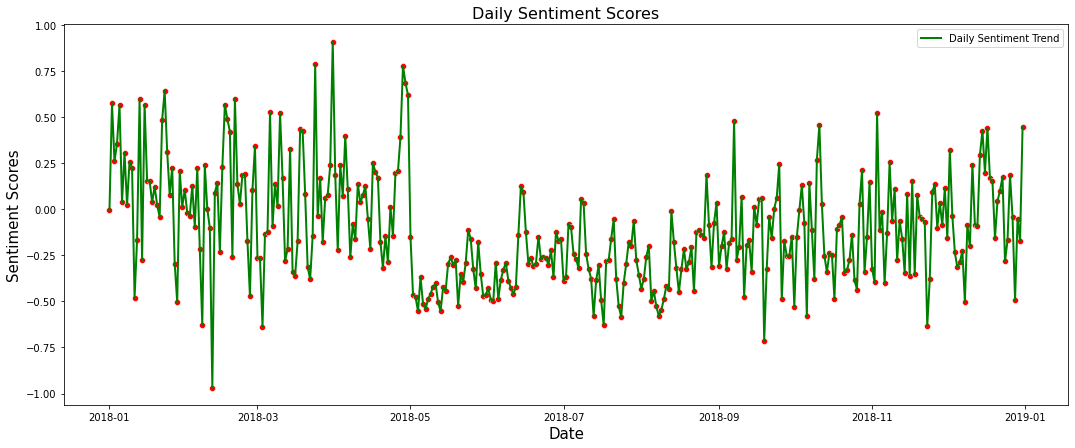

In [ ]:
fig,ax=plt.subplots(figsize=(18,7))
sns.scatterplot(data=sentiment_daily,x="Date",y="sentimentScores",color="r")
ax.plot(sentiment_daily.loc[:,'sentimentScores'], linestyle='-', linewidth=2, label='Daily Sentiment Trend',color="g")
plt.title("Daily Sentiment Scores",size=16)
ax.set_ylabel('Sentiment Scores',size=15)
ax.set_xlabel("Date",size=15)
ax.legend();
plt.show()

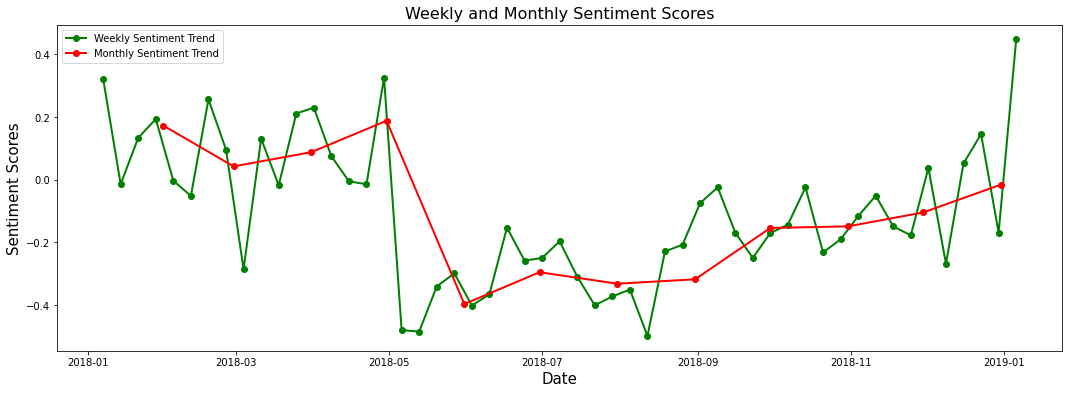

In [ ]:
sentiment_weekly=sentiment_data.resample('W', on='Date').mean()
sentiment_monthly=sentiment_data.resample('M', on='Date').mean()

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(sentiment_weekly.loc[:,'sentimentScores'], linestyle='-', linewidth=2, label='Weekly Sentiment Trend',color="g",marker="o")
ax.plot(sentiment_monthly.loc[:,'sentimentScores'], linestyle='-', linewidth=2, label='Monthly Sentiment Trend',color="r",marker="o")
plt.title("Weekly and Monthly Sentiment Scores",size=16)
ax.set_ylabel('Sentiment Scores',size=15)
ax.set_xlabel("Date",size=15)
ax.legend();
plt.show()

**Sentiment over space**

In [ ]:
sentiment_space = sentiment_data.groupby('City').mean().reset_index(drop=False)

In [ ]:
sentiment_space.head()

City  Relevance  sentimentScores  latitude  longitude
0        Aalst, België        1.0        -0.896729       NaN        NaN
1  Aargau, Switzerland        1.0        -0.994518       NaN        NaN
2          Abilene, TX        1.0         0.995357       NaN        NaN
3          Absecon, NJ        1.0         0.989794       NaN        NaN
4       Abuja, Nigeria        1.0        -0.845456       NaN        NaN

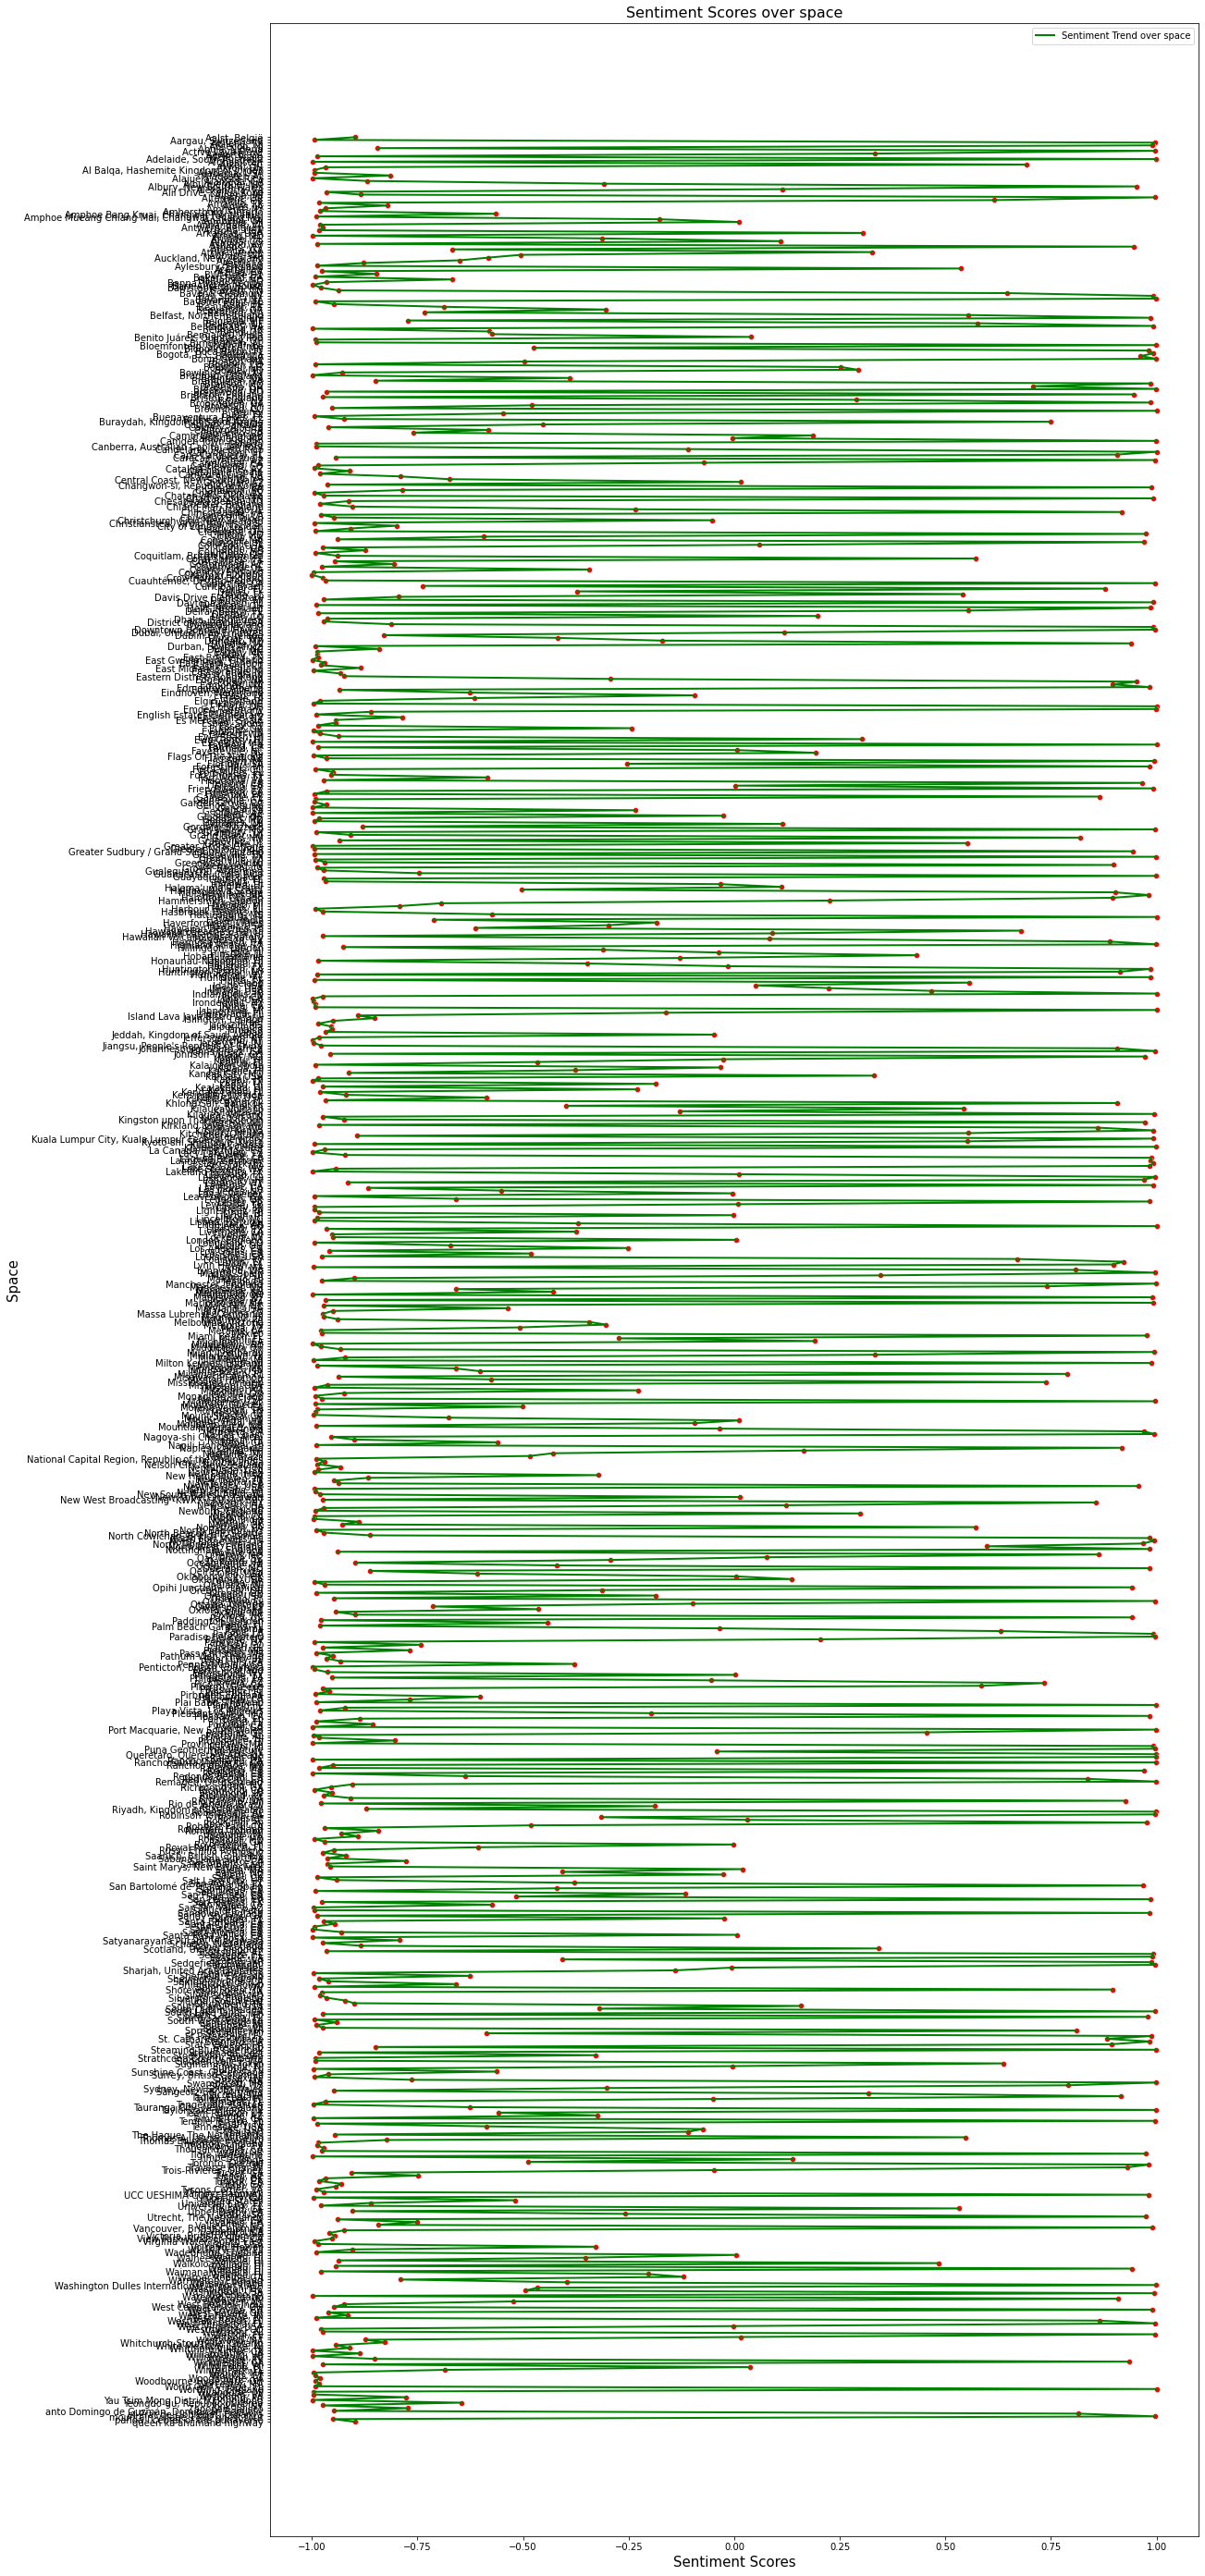

In [ ]:
fig,ax=plt.subplots(figsize=(18,50))
sns.scatterplot(data=sentiment_space,y="City",x="sentimentScores", color="r")
ax.plot(sentiment_space.loc[:,'sentimentScores'], sentiment_space.loc[:,'City'], linestyle='-', linewidth=2, label='Sentiment Trend over space',color="g")
plt.title("Sentiment Scores over space",size=16)
ax.set_ylabel('Space',size=15)
ax.set_xlabel("Sentiment Scores",size=15)
ax.legend();
plt.show()

The above plot is not clear due to more number of cities in the data. Let's plot positive & negative sentiment scores separately.

### Positive sentiment scores over space daily

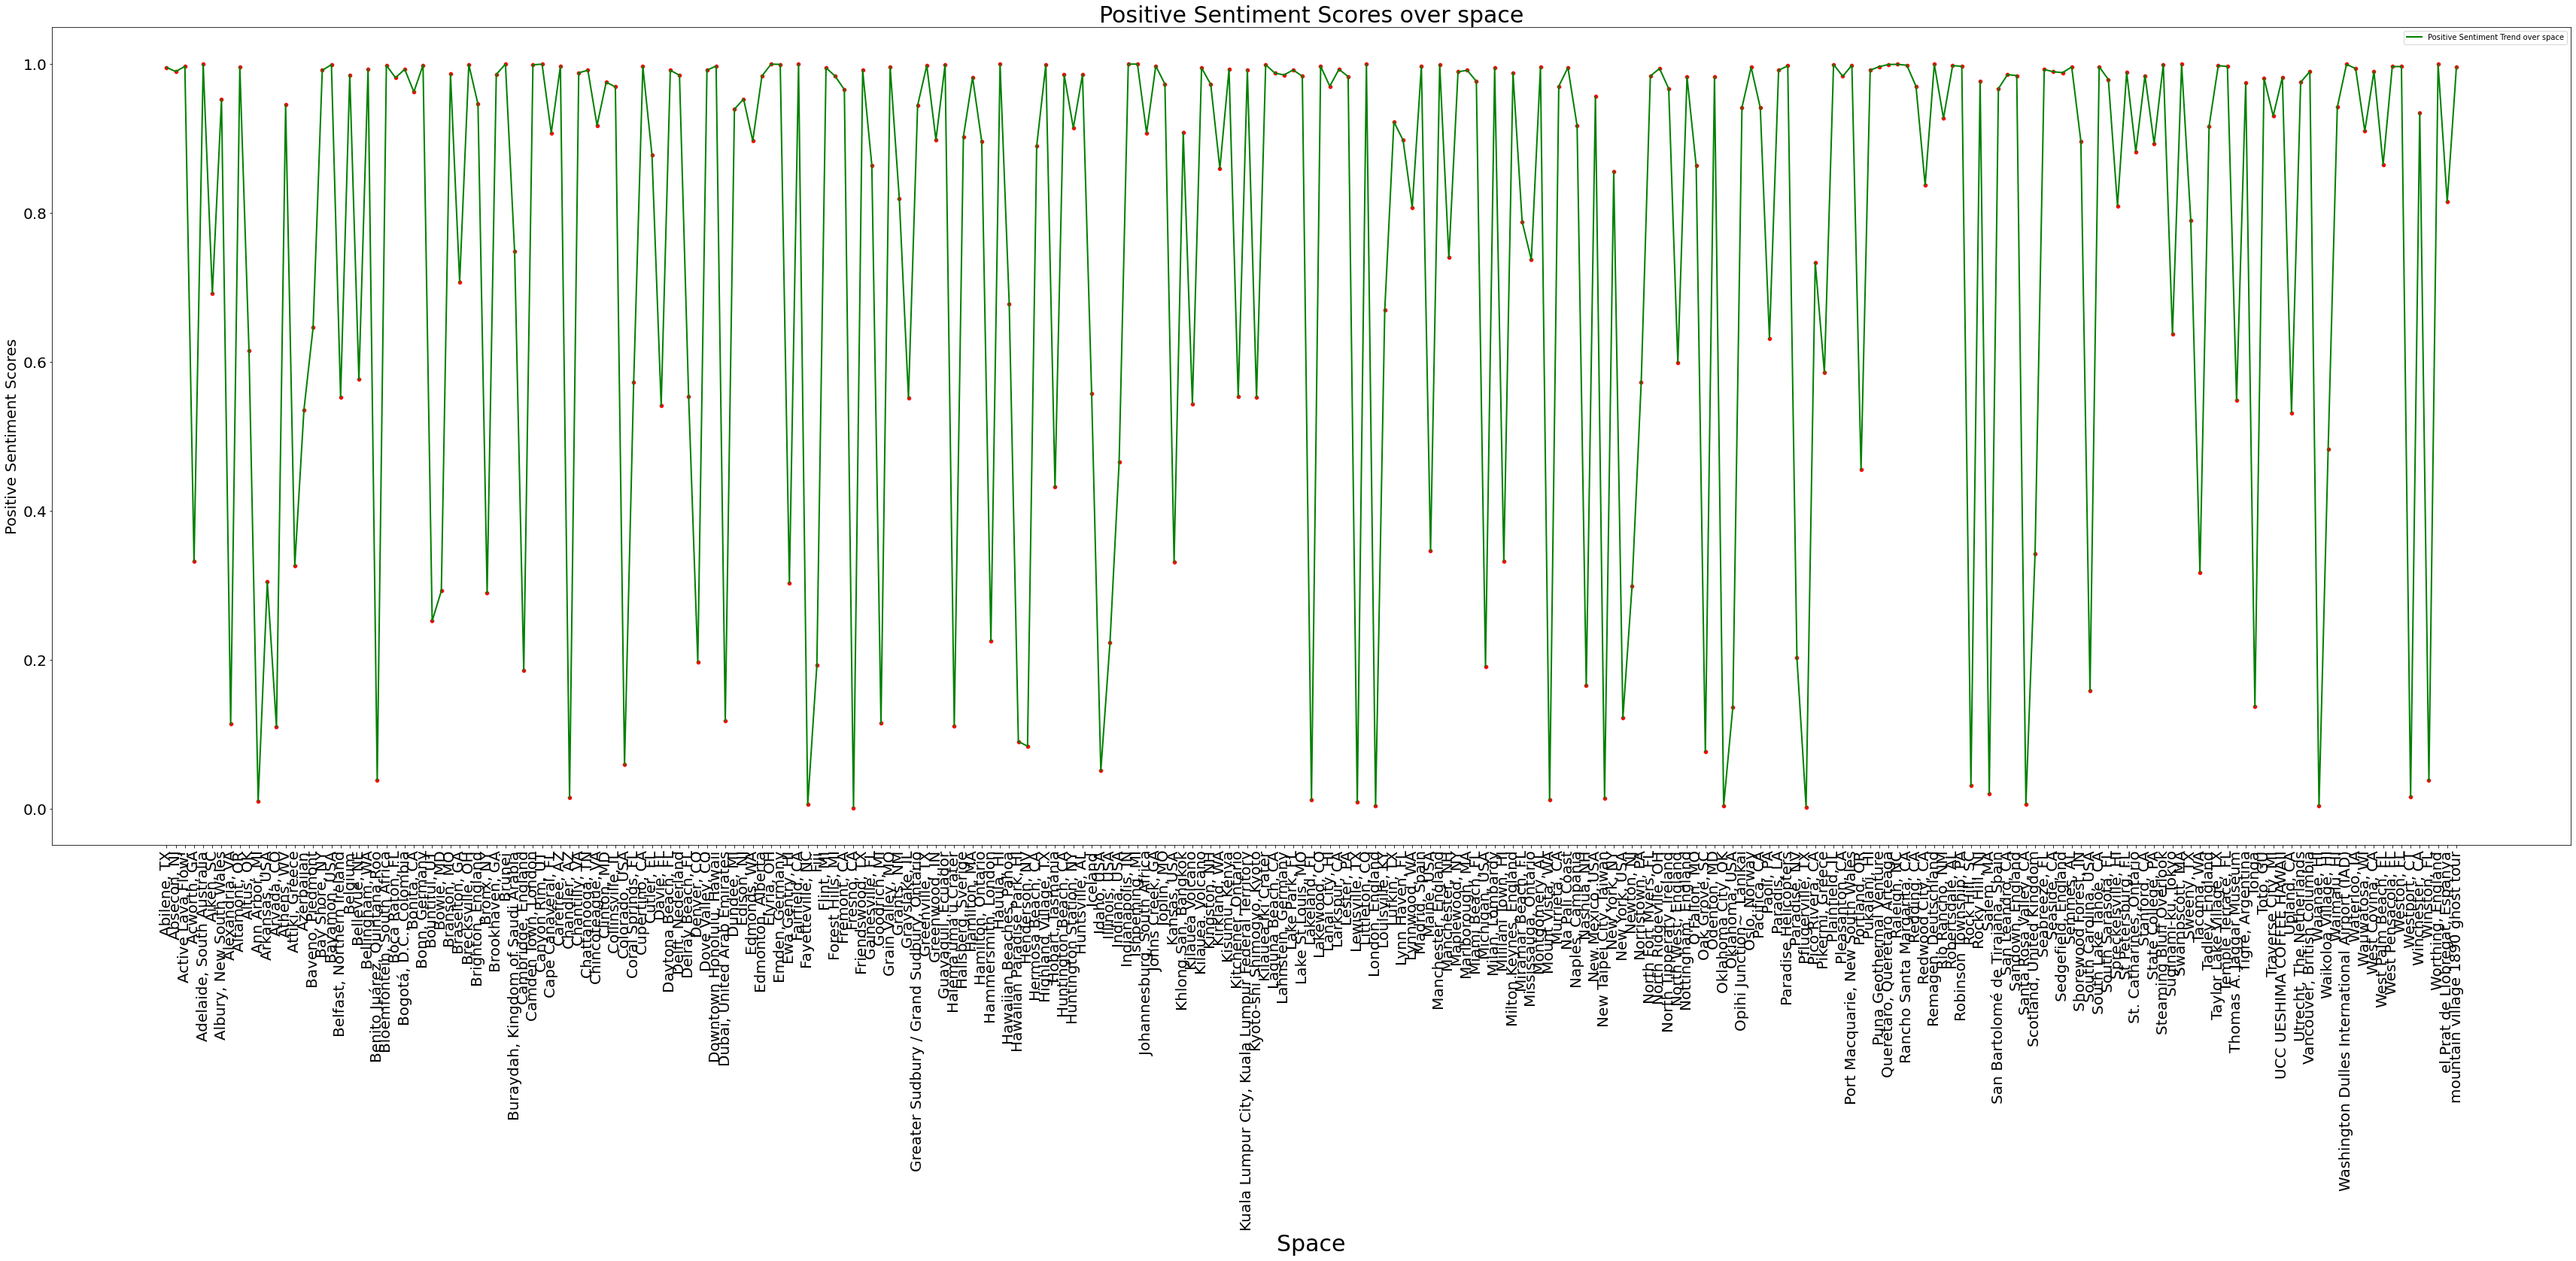

In [ ]:
# Sentiment Scores >=0
pos_sentiment_scores = sentiment_space[sentiment_space['sentimentScores']>=0]
fig,ax=plt.subplots(figsize=(60,20))
sns.scatterplot(data=pos_sentiment_scores,x="City", y="sentimentScores", color="r")
ax.plot(pos_sentiment_scores.loc[:,'City'], pos_sentiment_scores.loc[:,'sentimentScores'], linestyle='-', linewidth=2, label='Positive Sentiment Trend over space',color="g")
plt.title("Positive Sentiment Scores over space",size=30)
ax.set_ylabel('Positive Sentiment Scores',size=20)
ax.set_xlabel("Space",size=30)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
ax.legend();
plt.show()

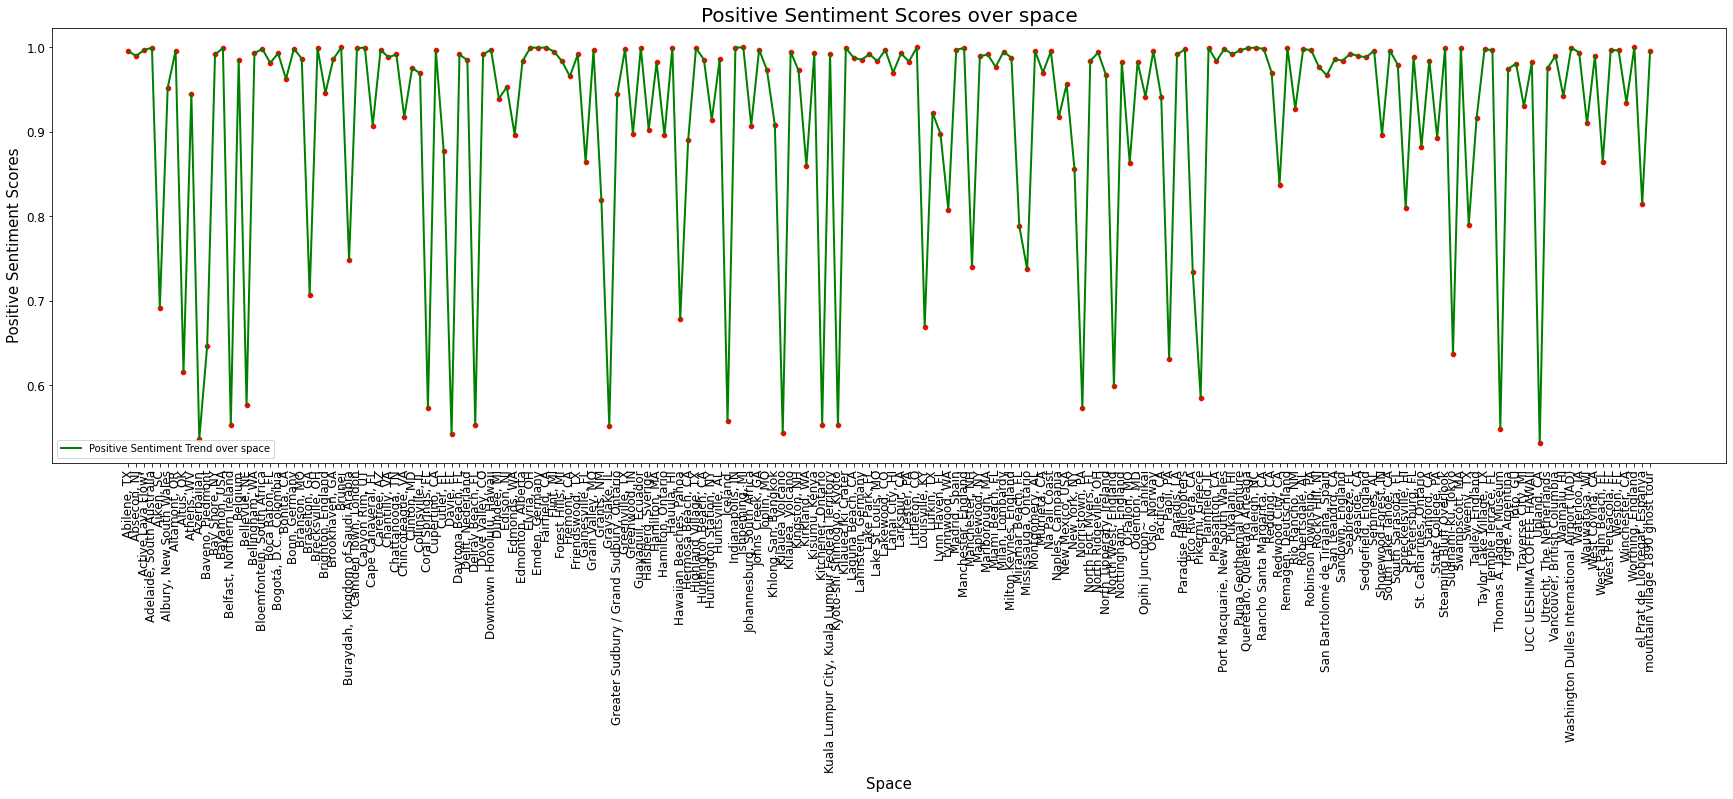

In [ ]:
# Sentiment Scores >=0.5
pos_sentiment_scores = sentiment_space[sentiment_space['sentimentScores']>=0.5]
fig,ax=plt.subplots(figsize=(30,8))
sns.scatterplot(data=pos_sentiment_scores,x="City", y="sentimentScores", color="r")
ax.plot(pos_sentiment_scores.loc[:,'City'], pos_sentiment_scores.loc[:,'sentimentScores'], linestyle='-', linewidth=2, label='Positive Sentiment Trend over space',color="g")
plt.title("Positive Sentiment Scores over space",size=20)
ax.set_ylabel('Positive Sentiment Scores',size=15)
ax.set_xlabel("Space",size=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
ax.legend();
plt.show()

### Negative sentiment scores over space daily

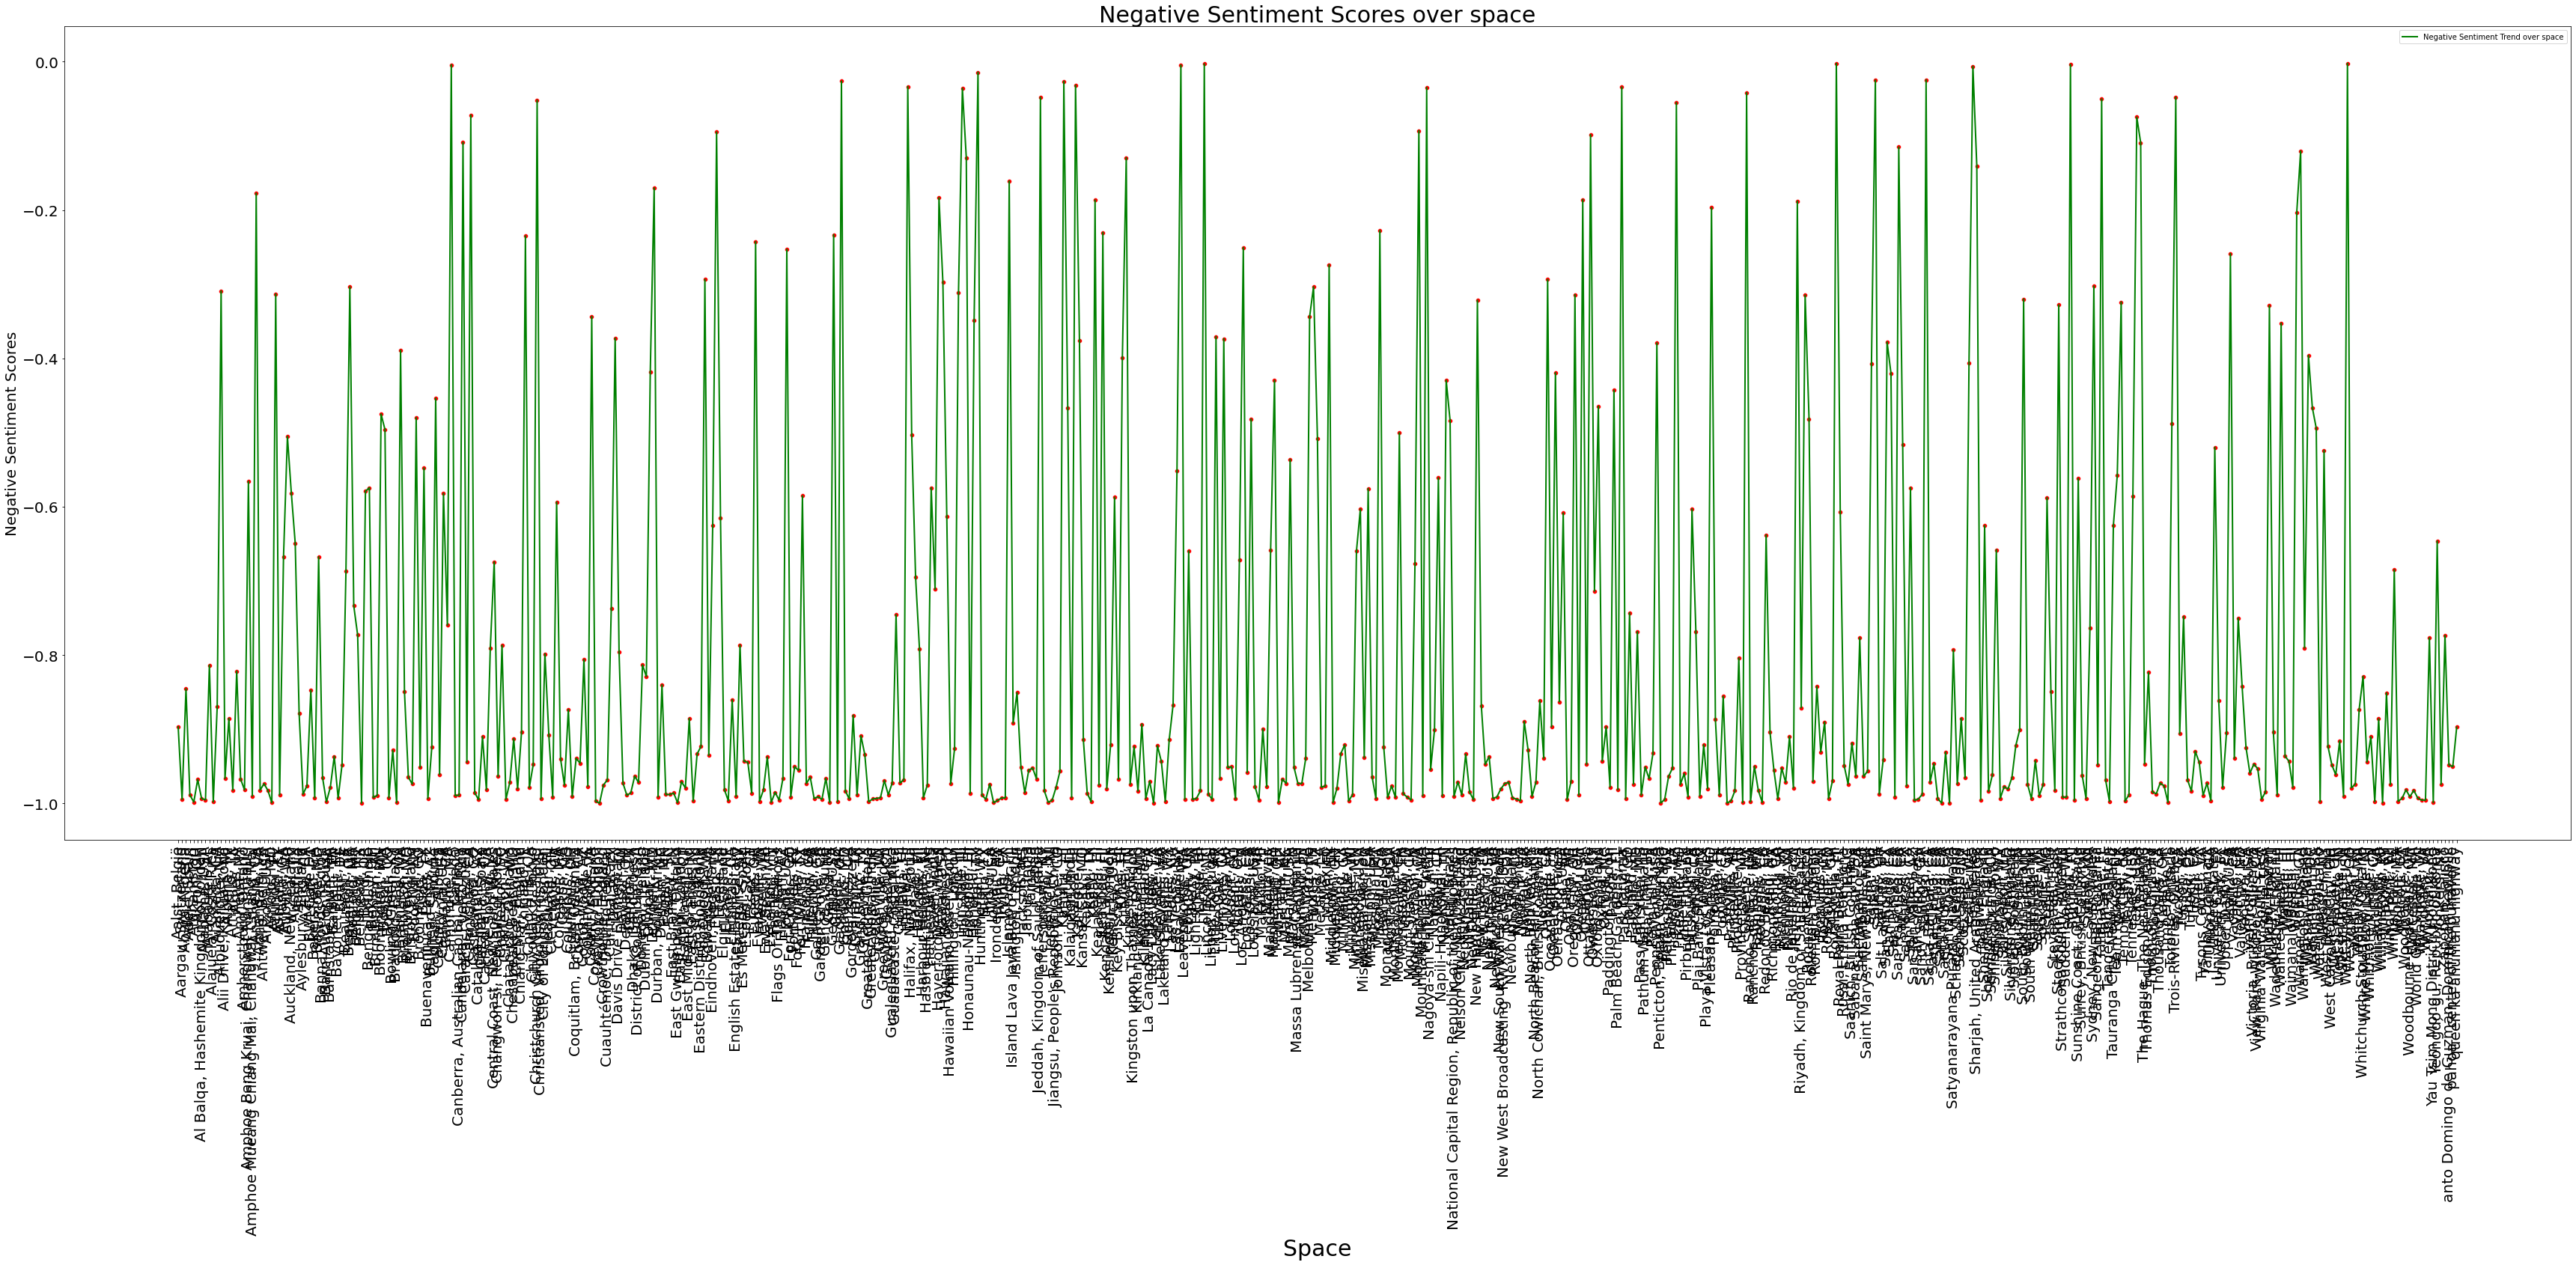

In [ ]:
# Sentiment Scores < 0
neg_sentiment_scores = sentiment_space[sentiment_space['sentimentScores']< 0]
fig,ax=plt.subplots(figsize=(60,20))
sns.scatterplot(data=neg_sentiment_scores,x="City", y="sentimentScores", color="r")
ax.plot(neg_sentiment_scores.loc[:,'City'], neg_sentiment_scores.loc[:,'sentimentScores'], linestyle='-', linewidth=2, label='Negative Sentiment Trend over space',color="g")
plt.title("Negative Sentiment Scores over space",size=30)
ax.set_ylabel('Negative Sentiment Scores',size=20)
ax.set_xlabel("Space",size=30)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
ax.legend();
plt.show()

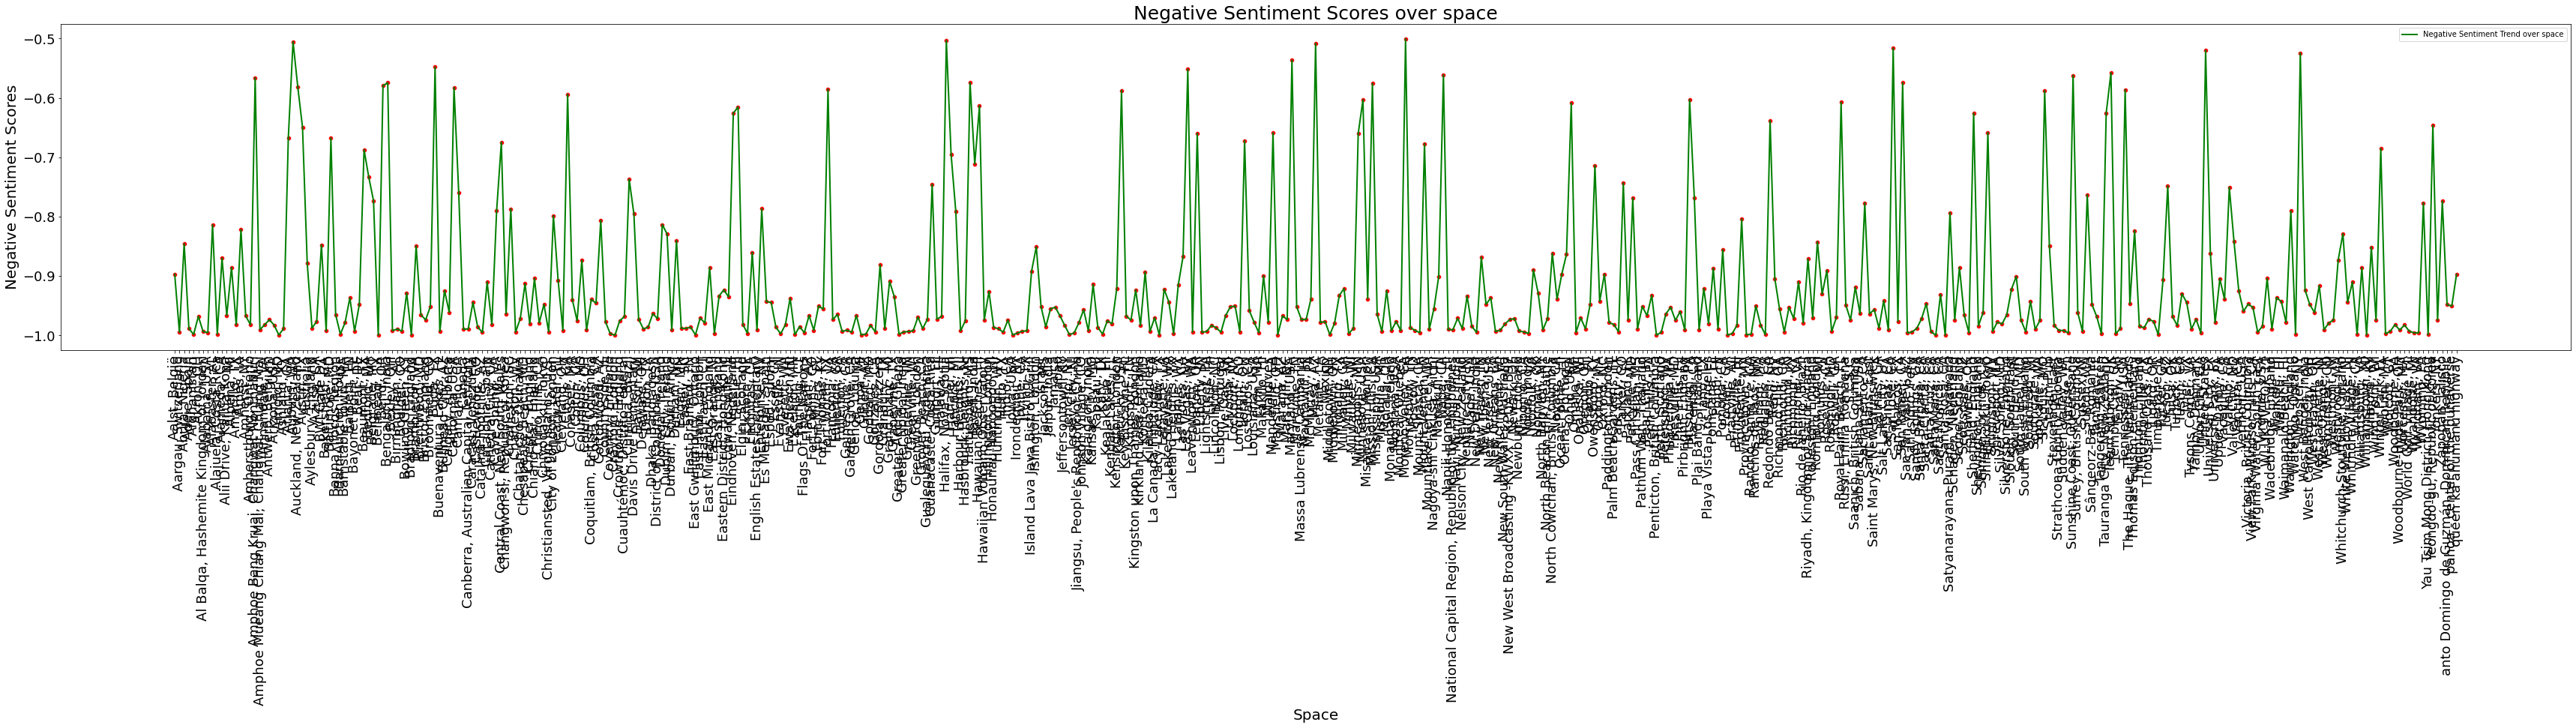

In [ ]:
# Sentiment Scores < 0.5
neg_sentiment_scores = sentiment_space[sentiment_space['sentimentScores']< -0.5]
fig,ax=plt.subplots(figsize=(60,8))
sns.scatterplot(data=neg_sentiment_scores,x="City", y="sentimentScores", color="r")
ax.plot(neg_sentiment_scores.loc[:,'City'], neg_sentiment_scores.loc[:,'sentimentScores'], linestyle='-', linewidth=2, label='Negative Sentiment Trend over space',color="g")
plt.title("Negative Sentiment Scores over space",size=25)
ax.set_ylabel('Negative Sentiment Scores',size=20)
ax.set_xlabel("Space",size=20)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
ax.legend();
plt.show()

4. **Time series of tweets in different categories.** 

In [ ]:
# Find the number of non relevant tweets
# Daily
tweets_daily_nrel=data_nonrel.resample('D', on='Date').count()
# Weekly
tweets_weekly_nrel= data_nonrel.resample('W', on='Date').count()
# Monthly
tweets_monthly_nrel= data_nonrel.resample('M', on='Date').count()

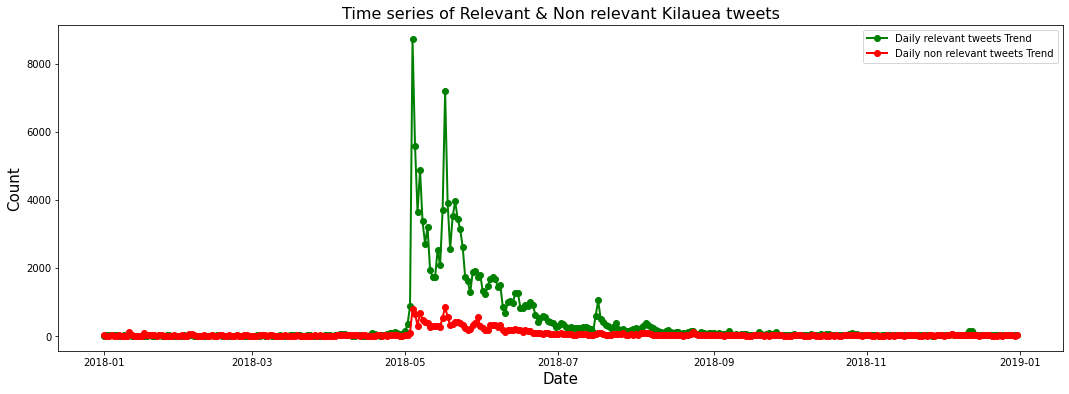

In [ ]:
# Daily
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(tweets_daily.loc[:,'Text'], linestyle='-', linewidth=2, label='Daily relevant tweets Trend',color="g",marker="o")
ax.plot(tweets_daily_nrel.loc[:,'Text'], linestyle='-', linewidth=2, label='Daily non relevant tweets Trend',color="r",marker="o")
plt.title("Time series of Relevant & Non relevant Kilauea tweets",size=16)
ax.set_ylabel('Count',size=15)
ax.set_xlabel("Date",size=15)
ax.legend();
plt.show()

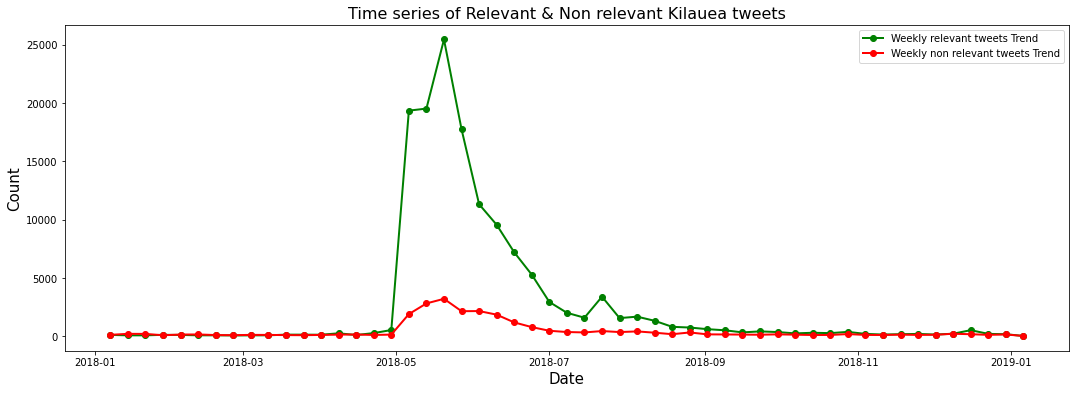

In [ ]:
# Weekly
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(tweets_weekly.loc[:,'Text'], linestyle='-', linewidth=2, label='Weekly relevant tweets Trend',color="g",marker="o")
ax.plot(tweets_weekly_nrel.loc[:,'Text'], linestyle='-', linewidth=2, label='Weekly non relevant tweets Trend',color="r",marker="o")
plt.title("Time series of Relevant & Non relevant Kilauea tweets",size=16)
ax.set_ylabel('Count',size=15)
ax.set_xlabel("Date",size=15)
ax.legend();
plt.show()

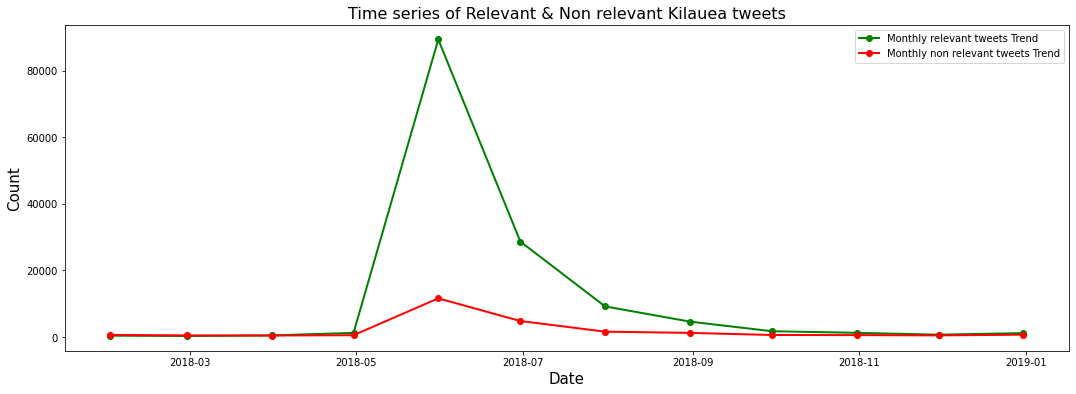

In [ ]:
# Monthly
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(tweets_monthly.loc[:,'Text'], linestyle='-', linewidth=2, label='Monthly relevant tweets Trend',color="g",marker="o")
ax.plot(tweets_monthly_nrel.loc[:,'Text'], linestyle='-', linewidth=2, label='Monthly non relevant tweets Trend',color="r",marker="o")
plt.title("Time series of Relevant & Non relevant Kilauea tweets",size=16)
ax.set_ylabel('Count',size=15)
ax.set_xlabel("Date",size=15)
ax.legend();
plt.show()

5. **Sources of information used by Twitter users evidenced by the main domains in shared URLs.**

In [ ]:
!pip install tldextract

     |████████████████████████████████| 87 kB 3.5 MB/s 


In [ ]:
# List the domains from tweets data
import urllib3
import tldextract

domains = []
tweets = volcanic_data.Text.tolist()

for tweet in tweets:
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet) 
    # If list is empty
    if not urls:
      domains.append('None')
    else:
      url = urls[0]           # Consider one shared url from each tweet
      try: 
        res = urllib3.urlopen(url)
        actual_url = res.geturl()
        # extract domain info
        ext = tldextract.extract(actual_url)
        domains.append(ext.registered_domain)
      except:
        # extract domain info
        ext = tldextract.extract(url)
        domains.append(ext.registered_domain)

In [ ]:
volcanic_data['Domains'] = domains
volcanic_data.head(12)

Text  ... Domains
0      dramatic images show hawaii’s kilauea volcano erupt\n\nlava spewed hundreds of feet into the air as the volcano kilau…    ...    None
1                 here's my top 5 in stories this year: 5. charter school co-founder looks to future after  kilauea eruption…    ...    None
2                                                         recent overflows are largest seen at kilauea lava lake in 10 years:    ...    None
3                                      happy new year! here's where to watch big island fireworks tonight    hawaii  kilauea…    ...    None
4        four ways kīlauea is redrawing the  map. from burying communities to building new land, this historic eruption is c…    ...    None
5               not surprising that it was all lava ... and  calebap  lava was a big deal in  2018  leilaniestates  bestnine…    ...    None
6                                                         recent overflows are largest seen at kilauea lava lake in 10 years:    ...    None
7        i foresee dark clouds for the 'cerebral' pelosi, ahead, and they're not kilauea volcano plumes of lava darkening th…    ...    None
8   may-\n•kilauea volcano sprays ash thousands of feet into the air. \n\n•the royal wedding takes place!\n\n•hugh grant and…    ...    None
9                                                                      2018willgodown as the year  hawaii increased in size.\n   ...    None
10                      kilauea’s 2018 eruption was the largest in the united states for almost 40 years. via  eruptionsblog…    ...    None
11        satellite compilation of ✨most memorable 2018 volcano eruptions✨: 🇵🇭 mayon, 🏴󠁵󠁳󠁨󠁩󠁿 kilauea and 🇮🇹 etna  caused min…    ...    None

[12 rows x 10 columns]

In [ ]:
volcanic_data['Domains'].unique()

array(['None'], dtype=object)

It seems the domain '' is empty. Let's convert this one to None.

In [ ]:
def get_domains(domain):
  if domain=='':
    return 'None'
  else:
    return domain

In [ ]:
volcanic_data['Domains'] = volcanic_data['Domains'].apply(get_domains)

In [ ]:
volcanic_data['Domains'].unique()

array(['None'], dtype=object)

In [ ]:
domains = volcanic_data[['Text','Domains']].groupby('Domains').count().reset_index(drop=False).rename(columns={'Text':'Count'})
domains = domains.sort_values('Count', ascending=False)
domains

Domains   Count
0    None  139410

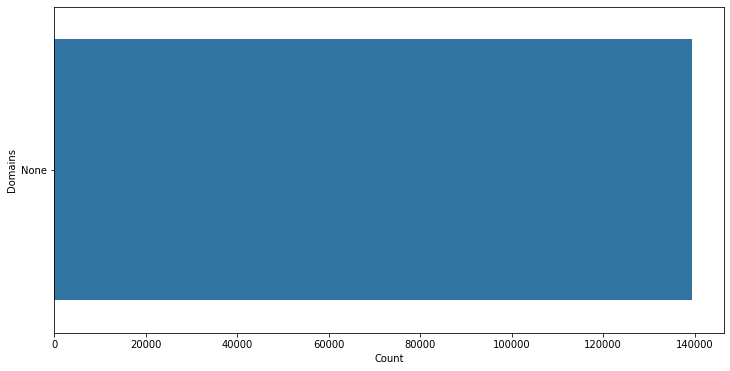

In [ ]:
#Plot bar plot
plt.figure(figsize=(12, 6))
sns.barplot(y='Domains', x='Count', data=domains)
plt.show();

**None** indicates no links mentioned in the tweets.

# Training Sentiment Analysis Model

In [ ]:
df_dominant_topic['Dominant_Topic'].unique()

array([9., 0., 2., 6., 5., 8., 3., 4., 1.])

In [ ]:
# selecting the topic 6 and topic 4 as they mimics topic mostly related to volcano
filtered_volcanic=df_dominant_topic[(df_dominant_topic["Dominant_Topic"]==6) | (df_dominant_topic["Dominant_Topic"]==4)]

In [ ]:
filtered_volcanic.shape

(10318, 5)

In [ ]:
filtered_volcanic.head()

Document_No  ...                                                                                          Text
12           12  ...                           rt actionmick new artwork sale kilauea fissure eight fineartamerica
16           16  ...                                         new artwork sale kilauea fissure eight fineartamerica
24           24  ...  cmclymer daughter wedding met great new people experienced kilauea eruption tragic many ways
27           27  ...    guardian america year extreme weather pictures features pictures hawaii kilauea volcano vo
28           28  ...               flies miles see lava kilauea erupting nearly continuously since may stopped cnn

[5 rows x 5 columns]

In [ ]:
# Reset index
filtered_volcanic = filtered_volcanic.reset_index(drop=True)

In [ ]:
nlp = pipeline('sentiment-analysis');
labels = []
scores = []
for i in range(len(filtered_volcanic)):
  result = nlp(filtered_volcanic['Text'][i]);
  label = result[0]['label']
  labels.append(result[0]['label'])
  if label=='NEGATIVE':
    scores.append(-1*result[0]['score'])
  else:
    scores.append(result[0]['score'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [ ]:
filtered_volcanic['SentimentClass'] = labels 
filtered_volcanic['SentimentScores'] = scores

In [ ]:
filtered_volcanic.head()

Document_No  Dominant_Topic  ...  SentimentClass SentimentScores
0           12             6.0  ...        POSITIVE        0.901555
1           16             6.0  ...        POSITIVE        0.980778
2           24             4.0  ...        NEGATIVE       -0.787441
3           27             6.0  ...        POSITIVE        0.962272
4           28             6.0  ...        NEGATIVE       -0.949230

[5 rows x 7 columns]

In [ ]:
# df_dominant_topic["sentiment"]=df_dominant_topic["Text"].apply(lambda x:sentimentAnalysisModel.polarity_scores(x))

In [ ]:
# df_dominant_topic["sentimentScores"]=df_dominant_topic["sentiment"].apply(lambda x: calculateHighestSentiment(x))
# del df_dominant_topic["sentiment"]

In [ ]:
# # divide the sentiment scores into three classes, where 1 means positive, 0 means neutral and -1 means negative
# def parseSentimentClass(sentimentScore):
#     if sentimentScore>0.5:
#         return 1
#     elif sentimentScore< -0.5:
#         return -1
#     else:
#         return 0

In [ ]:
# df_dominant_topic["sentimentClass"]=df_dominant_topic["sentimentScores"].apply(lambda x: parseSentimentClass(x))

In [ ]:
# df_dominant_topic.reset_index(drop=True,inplace=True)
# df_dominant_topic.head()